<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Make-RBC-Model" data-toc-modified-id="Make-RBC-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Make RBC Model</a></span><ul class="toc-item"><li><span><a href="#Model-Equations" data-toc-modified-id="Model-Equations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Model Equations</a></span></li><li><span><a href="#Find-Steady-State,-Solve-Model" data-toc-modified-id="Find-Steady-State,-Solve-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Find Steady State, Solve Model</a></span></li></ul></li><li><span><a href="#Get-US-data" data-toc-modified-id="Get-US-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get US data</a></span><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Check-stationarity-after-tranformation" data-toc-modified-id="Check-stationarity-after-tranformation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Check stationarity after tranformation</a></span></li></ul></li><li><span><a href="#Maximum-Likelihood-Estimation" data-toc-modified-id="Maximum-Likelihood-Estimation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Maximum Likelihood Estimation</a></span></li><li><span><a href="#MAP-Estimation" data-toc-modified-id="MAP-Estimation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MAP Estimation</a></span><ul class="toc-item"><li><span><a href="#Setting-Priors" data-toc-modified-id="Setting-Priors-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Setting Priors</a></span></li></ul></li><li><span><a href="#Full-Bayes" data-toc-modified-id="Full-Bayes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Full Bayes</a></span></li></ul></div>

In [1]:
%matplotlib inline

from gEcon.classes.model import gEconModel
from gEcon.plotting import plotting as gp
from gEcon.sampling.prior_utilities import kalman_filter_from_prior, kalman_filter_from_posterior, simulate_trajectories_from_posterior, \
    simulate_trajectories_from_prior
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import arviz as az

import sys
sys.path.append('..')
from TimeSeriesTools.stats import ADF_test_summary
from TimeSeriesTools.transformers import DetrendTransformer, LogTransformer

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

C:\Users\Jesse\Python Projects\gEcon.py\gEcon\estimation\kalman_filter.py:134: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  K = linalg.solve_triangular(F_chol, linalg.solve_triangular(F_chol, PZT.T, lower=True),


# Make RBC Model

In [2]:
rbc = gEconModel('GCN Files/RBC_complete.gcn')

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations

In [3]:
for equation in rbc.system_equations:
    display(equation)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve Model 

In [4]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  6.431134774067124e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [5]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
Y_ss               3.073
lambda_ss          0.276
r_ss               0.030
w_ss               2.436


# Get US data

We want series for consumption, investment, labor, GDP, interest rate, and wages

In [6]:
indicators = ['NAEXKP01USQ652S', # GDP
              'USAGFCFQDSMEI', # Investment
              'USAPFCEQDSMEI', # HH consumption
              'TOTLQ', # non-farm hours worked
              'FEDFUNDS', # real interest rate
              'CES0500000003' # average hourly wage
             ]

from pandas_datareader.fred import FredReader
import os

if not os.path.isfile('us_fred_data.csv'):
    data = FredReader(symbols=indicators, start='1900', end=None).read()
    data.to_csv('us_fred_data.csv')
else:
    data = pd.read_csv('us_fred_data.csv', index_col=0, parse_dates=['DATE'], infer_datetime_format=True)

<AxesSubplot: xlabel='DATE'>

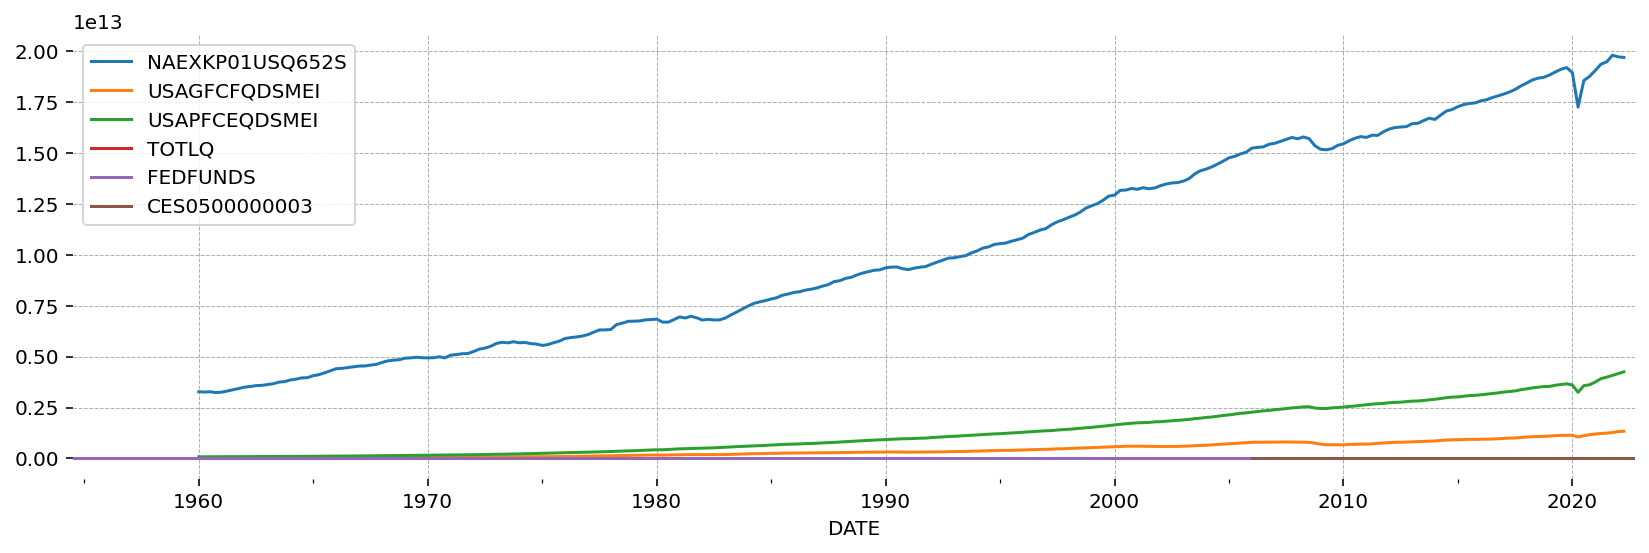

In [7]:
data.resample('QS').last().plot()

In [8]:
df = data.resample('QS').last()
df = df.rename(columns=dict(zip(indicators, ['Y', 'I', 'C', 'L', 'r', 'w'])))
df.index.name = 'Time'

# Regular at least 3 observed series
df.dropna(thresh=3, inplace=True)

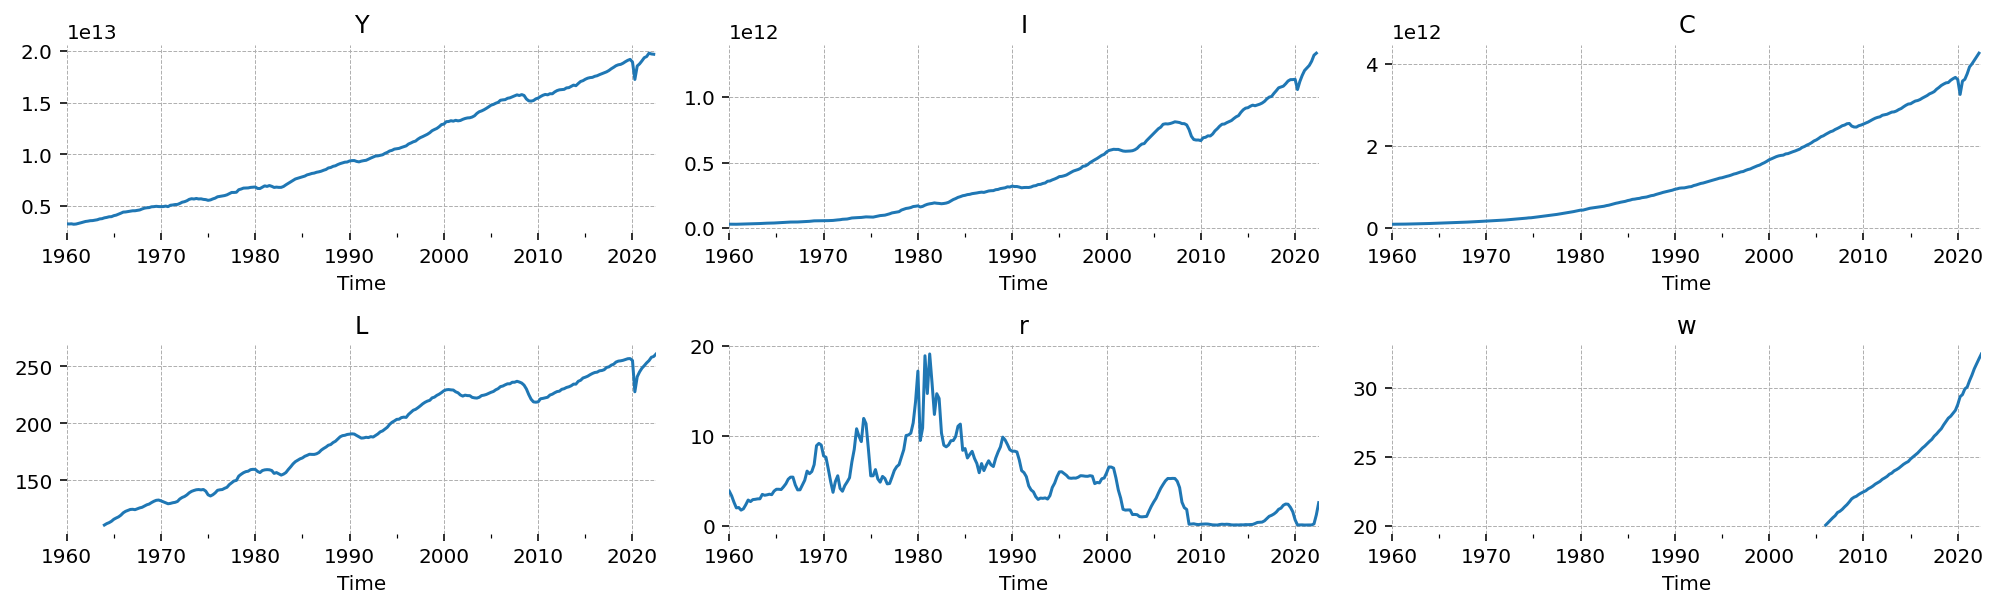

In [9]:
def plot_df(df):
    fig = plt.figure(figsize=(14,6), dpi=144)
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=df.shape[1])

    for loc, var in zip(plot_locs, df):
        axis = fig.add_subplot(gs[loc])
        df[var].plot(ax=axis)
        axis.set_title(var)

    fig.tight_layout()
    plt.show()
    
plot_df(df)

## Preprocessing

These all need to be logged and de-trended. I'll use an OLS regression to remove the trend. Interest rates are already a percentage, so they don't need to be logged. They do need to be converted to decimal, though.

All the series are seasonally adjusted and in constant chained dollars. Actually I don't know if this is correct. It might be more correct to use raw series. There's no prices in this model so I don't think it matters, but in a full New Keynesian model with a monetary authority it might be correct to use unadjusted data. Need to check that data preparation paper again.

In [10]:
from sklearn.pipeline import Pipeline

df['r'] = df['r'].mul(1e-2).add(1)

# I programmed the LogTransformer to do a generalized Cox-Box transformation. Lambda = 0 correpsonds to just taking the log.
# Linear detrend was still non-stationary in ADF, so I took out a quadratic trend.
preprocessing = Pipeline([('log_transformer', LogTransformer(lamb=0, columns=['Y', 'I', 'C', 'L', 'w'])),
                          ('OLS_detrend', DetrendTransformer(trend='ctt'))])

df = preprocessing.fit_transform(df)

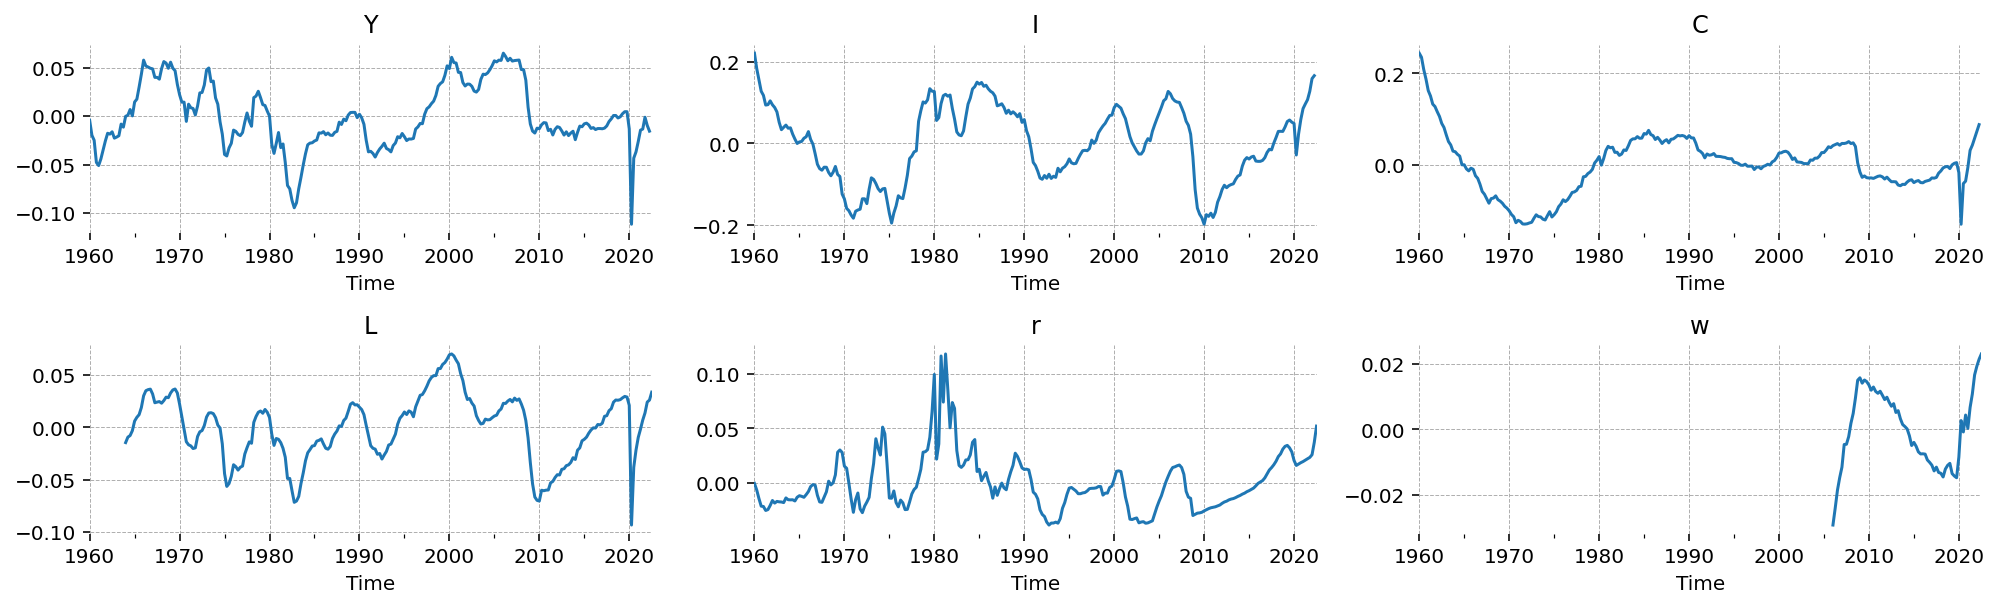

In [11]:
plot_df(df)

## Check stationarity after tranformation

It's sort of suprising that these are ruled stationarity, I would haved expected that with the big shocks in 2008 and 2020, the ADF test would complain. Could double-check with DFGLS and KPSS, but I think it's good enough for this example.

In [12]:
ADF_test_summary(df, missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.055         -2.622        0.270          0    -3.996      -3.428     -3.137
	Constant             0.000          0.136        0.892
	Trend               -0.000         -0.192        0.848
Constant Only               -0.055         -2.628        0.087          0    -3.457      -2.873     -2.573
	Constant            -0.000         -0.060        0.952
No Constant                 -0.055         -2.633        0.008          0    -2.575      -1.942     -1.616
                                                      I                                                       
Specification               Coeff          Statistic     P-value      La

# Maximum Likelihood Estimation

In [13]:
from gEcon.shared.statsmodel_convert import compile_to_statsmodels

MLEModel = compile_to_statsmodels(rbc)

In [41]:
calibrated_params = {'beta':0.98, 'alpha':0.35, 'sigma_L':2.0, 'delta':0.05}
rbc.free_param_dict.update(calibrated_params)

To perform maximum likelihood estimation, we will need to help the optimizer along. We will do this by providing bijective transformations between an unconstrained optimizer space and a constrained parameter space. 

For example, suppose we want to sample a variance parameter, which can only be positive. We will allow the sampler to choose any value it likes, then square the choice. We will use the square of the choice to compute the likelihood. Essentially, we perform strategic change-of-variables to make our lives easier.

Statsmodels can handle all the math for us, we just need to provide a dictonary of transformations. We will use two: `PositiveTransformer`, which constrains parameters to be positive, and `IntervalTransformer`, which constrains parameters to be within a set boundary.

In addition, since we want to show the model 6 time series, but we only have one stochastic shock in our model, we will need to add at least 5 measurement noises. We can do this by specificy values for `noise_start_dict`. Any data without a starting value will be assumed to be perfectly measured.

In [57]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

param_start_dict = {'sigma_C':1.5, 
                    'sigma_L':2.0,
#                     'alpha':0.5,
                    'rho_A':0.85}

shock_start_dict = {
    'epsilon_A':0.5
}

noise_start_dict = {
#     'Y':0.01,
    'C':0.02,
    'L':0.05,
    'I':0.02,
    'r':0.03,
    'w':0.1
}

# The slope parameter controls the steepness of the gradient around 0 (lower slope = more gentle gradient)
param_transforms = {
    'sigma_C': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'sigma_L': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-4, high=0.99, slope=1),
#     'alpha':IntervalTransformer(low=0.1, high=0.80, slope=1)
}

mle_mod = MLEModel(df,
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [58]:
mle_res = mle_mod.fit(method='nm', maxiter=10_000)
mle_res = mle_mod.fit(method='lbfgs', maxiter=1_000, start_params=mle_res.params)

Optimization terminated successfully.
         Current function value: -8.909303
         Iterations: 1264
         Function evaluations: 1934


In [59]:
mle_res.summary()

C:\Users\Jesse\miniconda3\envs\econ\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'I', 'C', 'L', 'r', 'w']   No. Observations:                  251
Model:                                  DSGEModel   Log Likelihood                 807.834
Date:                            Sun, 13 Nov 2022   AIC                          -1597.668
Time:                                    15:39:21   BIC                          -1565.939
Sample:                                01-01-1960   HQIC                         -1584.900
                                     - 07-01-2022                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma_C              1.0500      5.874      0.179      0.858     -10.463      12.563
sigma_L             10.0000    539.891      0.019      0.985   -1048.167    1068.167
rho_A                0.9900      0.046     21.710      0.000       0.901       1.079
sigma2.epsilon_A     0.0119      0.042      0.280      0.780      -0.071       0.095
sigma2.C             0.1284      0.325      0.395      0.693      -0.509       0.766
sigma2.L             0.0687      0.122      0.562      0.574      -0.171       0.308
sigma2.I             0.0330      0.022      1.527      0.127      -0.009       0.075
sigma2.r             0.0452      0.104      0.434      0.664      -0.159       0.249
sigma2.w             0.0394      0.013      3.081      0.002       0.014       0.064
======================================================================================================================================
Ljung-Box (L1) (Q):     0.13, 237.18, 236.02, 225.01, 207.94, 171.72   Jarque-Bera (JB):   9943.80, 7.86, 14.97, 3.55, 225.24, 1868.68
Prob(Q):                          0.72, 0.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):                    0.00, 0.02, 0.00, 0.17, 0.00, 0.00
Heteroskedasticity (H):            2.09, 0.36, 0.06, 2.15, 0.44, inf   Skew:                     -1.91, 0.34, 0.37, -0.29, 1.58, -1.16
Prob(H) (two-sided):              0.00, 0.00, 0.00, 0.00, 0.00, 0.00   Kurtosis:                  33.60, 2.47, 3.95, 3.01, 6.39, 16.16
======================================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

In [68]:
def plot_sm_results(res, filter_output='predicted'):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = mle_res.states.predicted.columns
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(mle_res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(mle_res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            mle_res.data.orig_endog[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

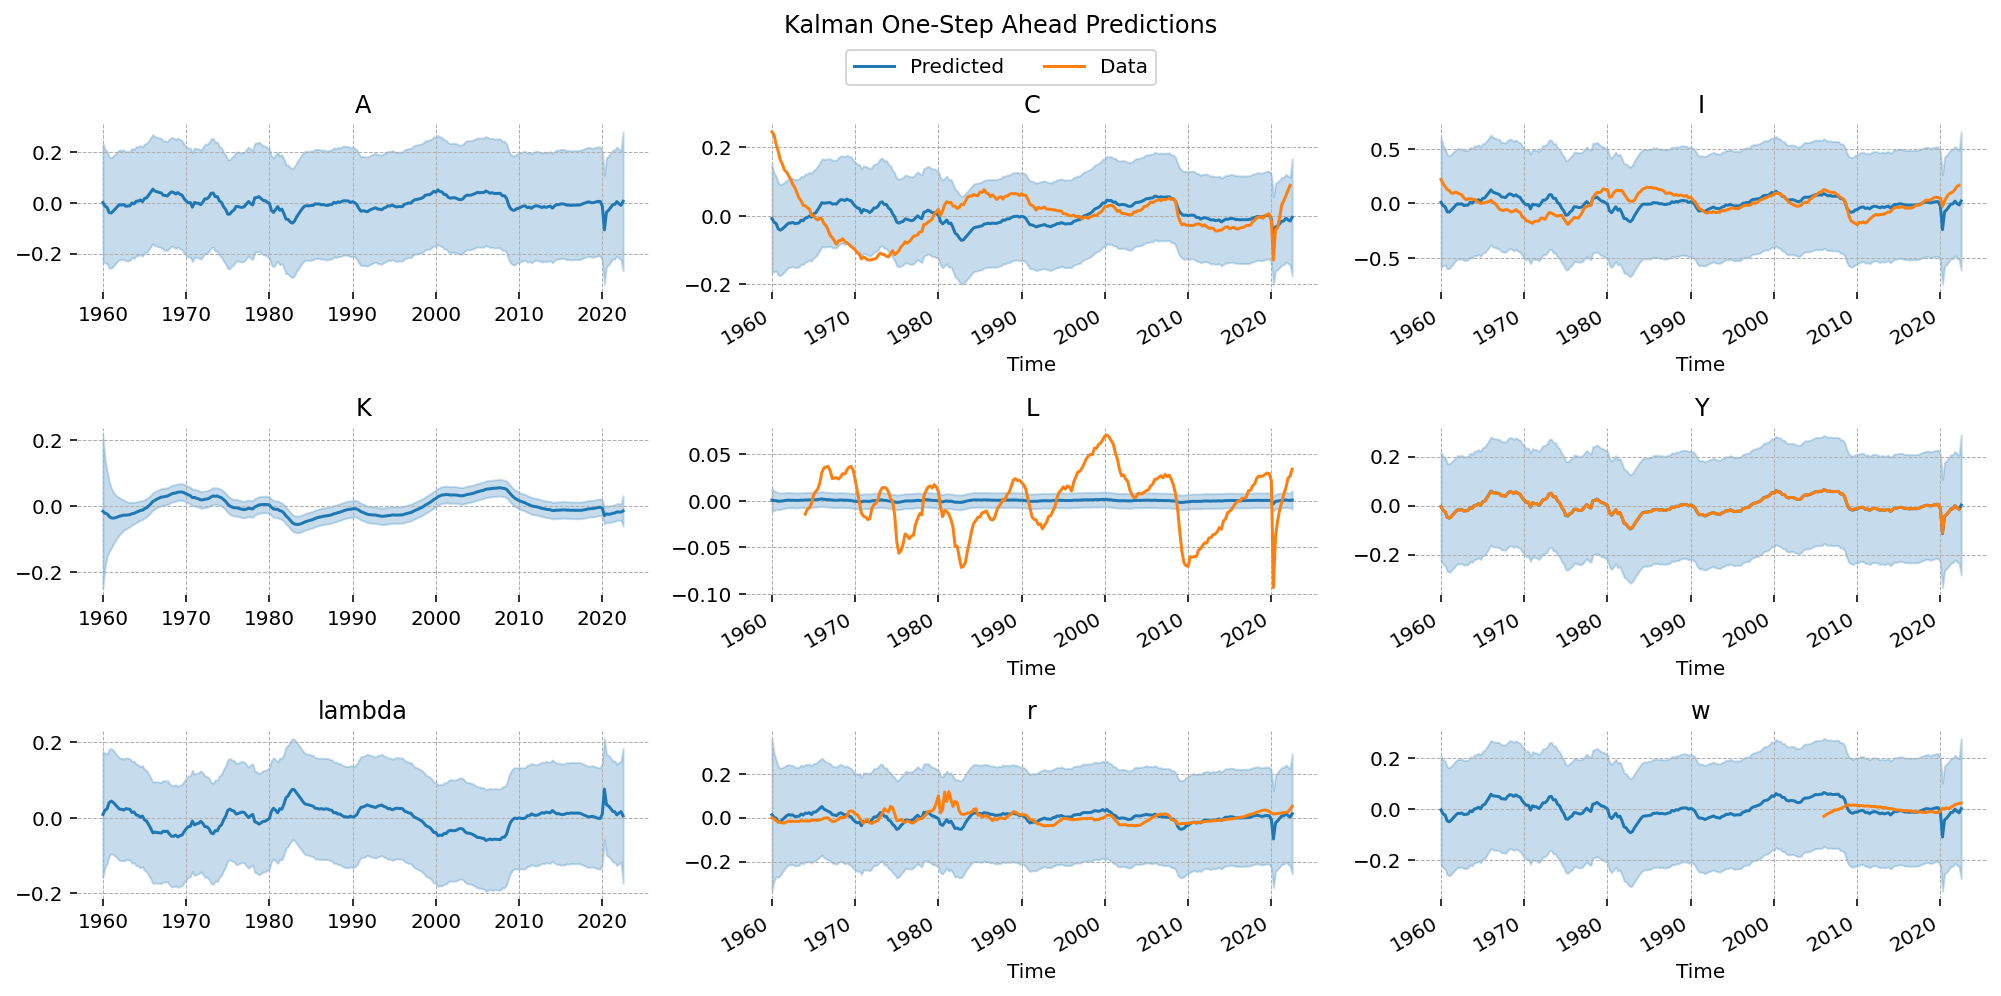

In [61]:
plot_sm_results(mle_res)

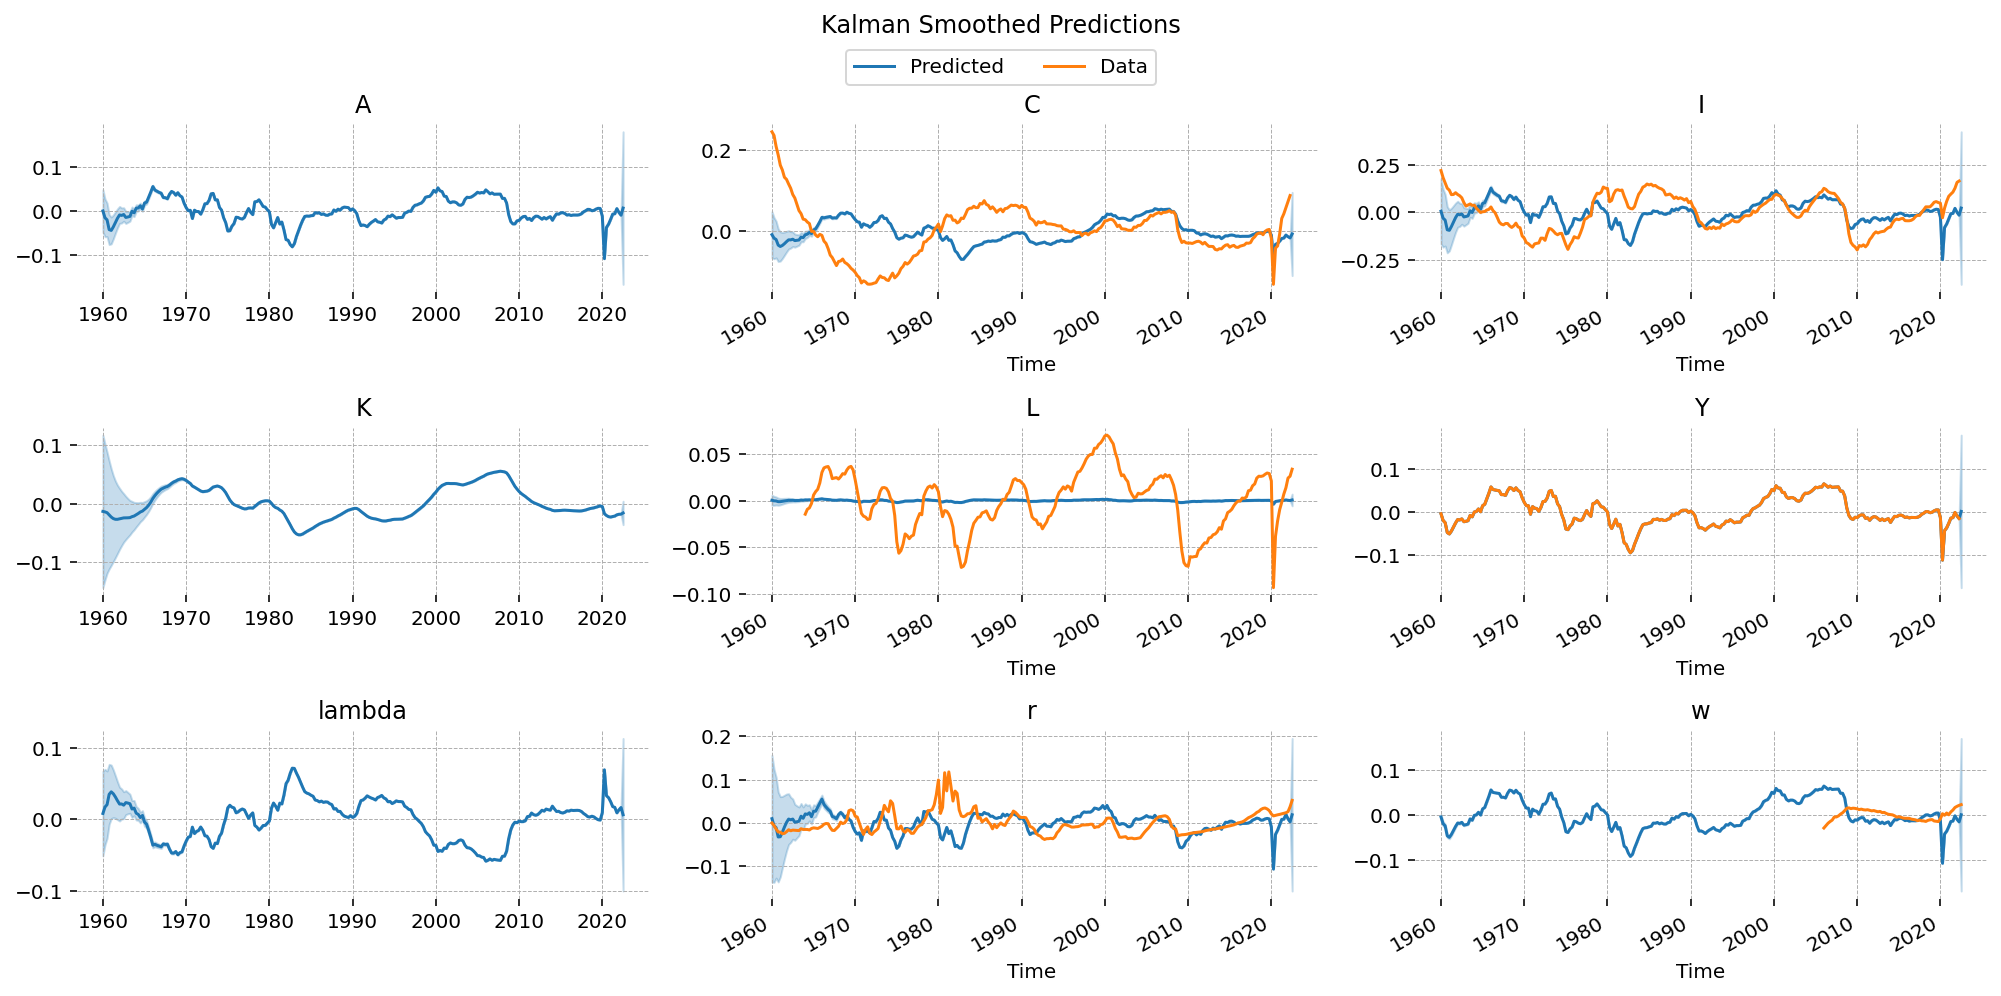

In [69]:
plot_sm_results(mle_res, 'smoothed')

In [70]:
irf_df = mle_res.impulse_responses(impulse=0, steps=40, orthogonalized=False)
irf_df.index = pd.MultiIndex.from_product([irf_df.index, ['epsilon_A']], names=['Time', 'Shocks'])
irf_df.columns.name = 'Variables'

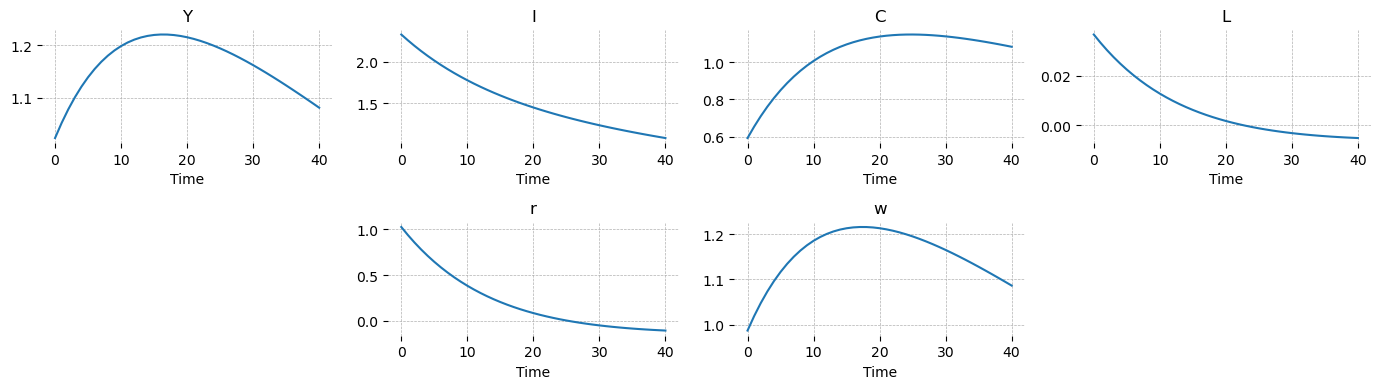

In [71]:
fig = gp.plot_irf(irf_df.T, shocks_to_plot='epsilon_A', figsize=(14,4))
plt.show()

# MAP Estimation

An alternative to maximum likelihood estimation is Maximum Aposterioi estimation, or MAP. MAP assigns priors to all the parameters in the model, and maximizes the posterior distribution given by Bayes' Law:

$$\text{Posterior} = \frac{\text{Likelihood}\cdot\text{Prior}}{\text{Evidence}}$$

The "evidence" is just a constant, so we can ignore it for maximization. Taking logs, we get:

$$\max_\theta \log\text{Posterior} = \log \text{Likelihood} + \log \text{Prior}$$

If the log Prior term is zero, this is exactly maximum likelihood estimation, which chooses parameters $\theta$ to maximize the log likelihood. So we're doing a regularized maximum likelihood, based on knowledge we have about what the parameter values are likely to be. 

As an additional benefit, we will no longer need to use transformations. If the optimizer tries to choose a value outside of the support of the prior, the log prior term will be negative infinity.

## Setting Priors

In [72]:
from scipy import stats

# Define priors for the observation noise

rbc.observation_noise_priors.update({
    'Y': stats.gamma(2, scale=1/20), # Trust Y more
    'C': stats.gamma(2, scale=1/10),
    'L': stats.gamma(2, scale=1/8), # Trust L less
    'I': stats.gamma(2, scale=1/10),
    'r': stats.gamma(2, scale=1/10),
    'w': stats.gamma(2, scale=1/10), # Trust w even less
})

Note the differences in the x-axis!

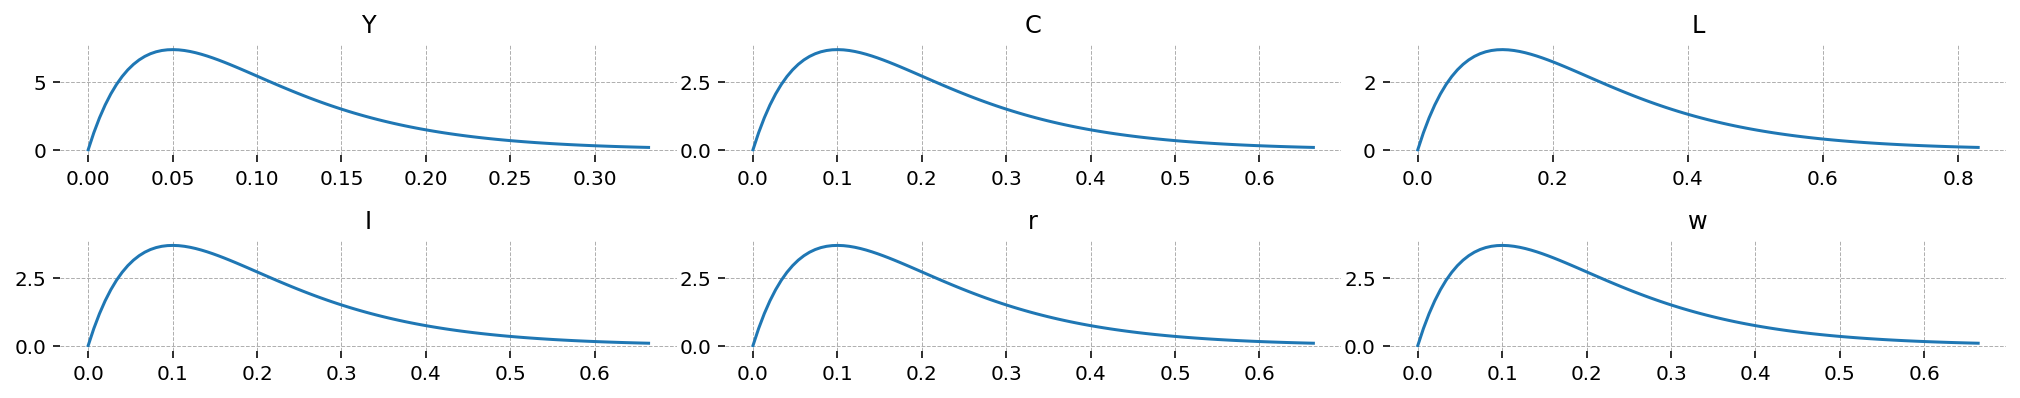

In [73]:
fig = plt.figure()
gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

for (name, d), loc in zip(rbc.observation_noise_priors.items(), plot_locs):
    x_grid = np.linspace(0, d.isf(0.01), 100)
    axis = fig.add_subplot(gs[loc])
    axis.plot(x_grid, d.pdf(x_grid))
    axis.set_title(name)
fig.tight_layout()
plt.show()

Priors for the other parameters were already defined in the GCN file

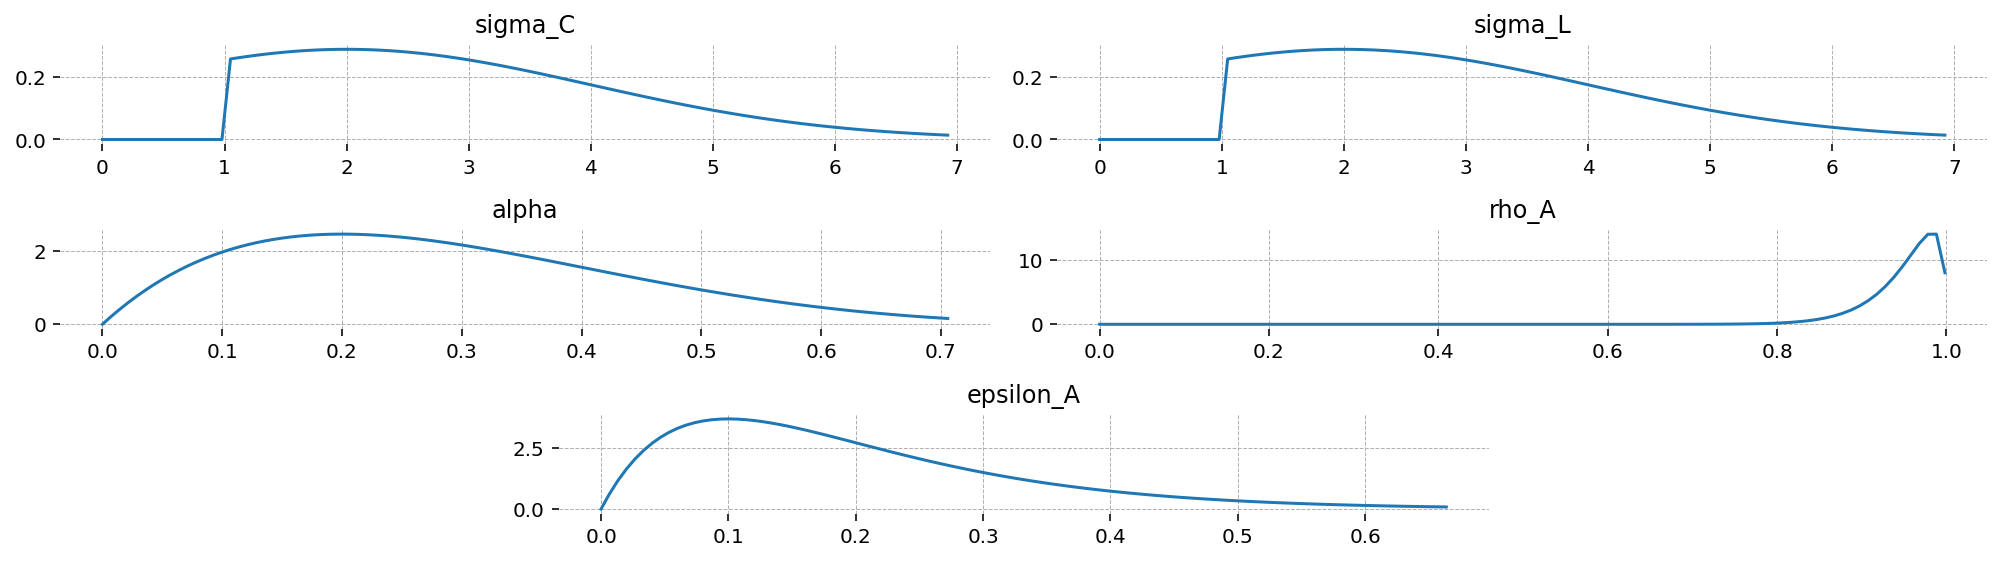

In [74]:
fig = plt.figure()
gs, plot_locs = gp.prepare_gridspec_figure(n_cols=2, n_plots=5)

all_priors = rbc.param_priors.copy()
all_priors.update({'epsilon_A':v for k,v in rbc.shock_priors['epsilon_A'].rv_params.items()})

for (name, d), loc in zip(all_priors.items(), plot_locs):
    x_grid = np.linspace(0, d.isf(0.01), 100)
    axis = fig.add_subplot(gs[loc])
    axis.plot(x_grid, d.pdf(x_grid))
    axis.set_title(name)
fig.tight_layout()
plt.show()

In [75]:
map_mod = MLEModel(df,
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = {}, # An empty transform dict will default to no transform for everything
               shock_transforms={}, 
               noise_transforms={},
               fit_MAP = True,
               initialization='stationary')

Parameter sigma_C was not assigned a transformation, assigning IdentityTransform
Parameter sigma_L was not assigned a transformation, assigning IdentityTransform
Parameter rho_A was not assigned a transformation, assigning IdentityTransform
Shock epsilon_A was not assigned a transformation, assigning IdentityTransform
Noise for state C was not assigned a transformation, assigning IdentityTransform
Noise for state L was not assigned a transformation, assigning IdentityTransform
Noise for state I was not assigned a transformation, assigning IdentityTransform
Noise for state r was not assigned a transformation, assigning IdentityTransform
Noise for state w was not assigned a transformation, assigning IdentityTransform


In [76]:
map_res = map_mod.fit(method='nm', maxiter=10_000)
map_res = map_mod.fit(method='lbfgs', start_params=map_res.params, maxiter=1_000)

Optimization terminated successfully.
         Current function value: -4.586673
         Iterations: 875
         Function evaluations: 1373


In [77]:
map_res.summary()

C:\Users\Jesse\miniconda3\envs\econ\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'I', 'C', 'L', 'r', 'w']   No. Observations:                  251
Model:                                  DSGEModel   Log Likelihood                1155.459
Date:                            Sun, 13 Nov 2022   AIC                          -2292.918
Time:                                    15:41:04   BIC                          -2261.189
Sample:                                01-01-1960   HQIC                         -2280.150
                                     - 07-01-2022                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma_C              1.0000    7.7e-08    1.3e+07      0.000       1.000       1.000
sigma_L              1.0000   9.63e-11   1.04e+10      0.000       1.000       1.000
rho_A                0.8466   2.16e-07   3.92e+06      0.000       0.847       0.847
sigma2.epsilon_A     0.1141   1.33e-07   8.61e+05      0.000       0.114       0.114
sigma2.C             0.0488   7.06e-06   6902.799      0.000       0.049       0.049
sigma2.L             0.0043      0.000     12.522      0.000       0.004       0.005
sigma2.I             0.0007   7.19e-05      9.378      0.000       0.001       0.001
sigma2.r             0.0177   3.41e-06   5195.834      0.000       0.018       0.018
sigma2.w             0.3449   3.76e-07   9.18e+05      0.000       0.345       0.345
======================================================================================================================================
Ljung-Box (L1) (Q):     3.23, 227.38, 236.59, 230.94, 193.73, 181.83   Jarque-Bera (JB):   8635.70, 47.56, 0.28, 1.90, 202.22, 1754.39
Prob(Q):                          0.07, 0.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):                    0.00, 0.00, 0.87, 0.39, 0.00, 0.00
Heteroskedasticity (H):            1.88, 0.23, 0.09, 2.30, 0.23, inf   Skew:                    -2.69, 0.93, -0.07, -0.18, 1.62, -2.10
Prob(H) (two-sided):              0.00, 0.00, 0.00, 0.00, 0.00, 0.00   Kurtosis:                  31.23, 4.06, 3.07, 2.78, 5.98, 15.25
======================================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
[2] Covariance matrix is singular or near-singular, with condition number 1.15e+23. Standard errors may be unstable.
"""

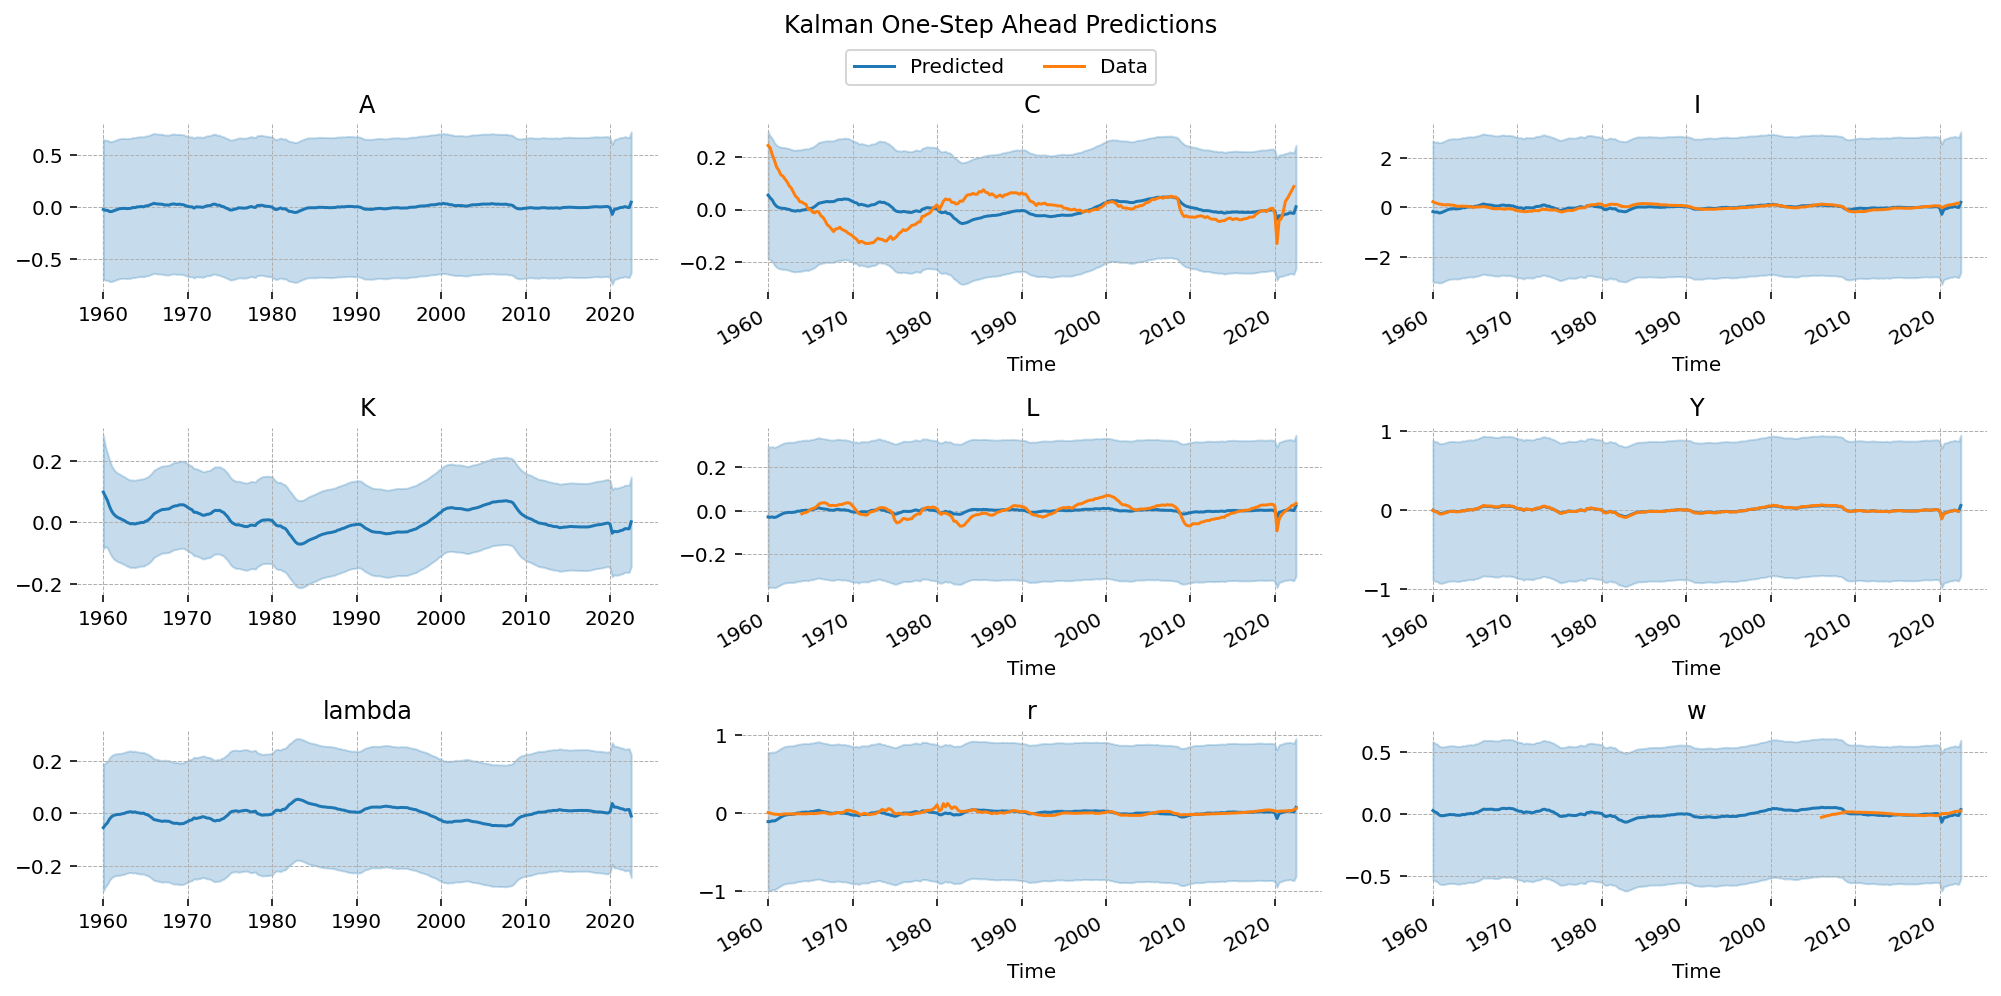

In [78]:
plot_sm_results(map_res)

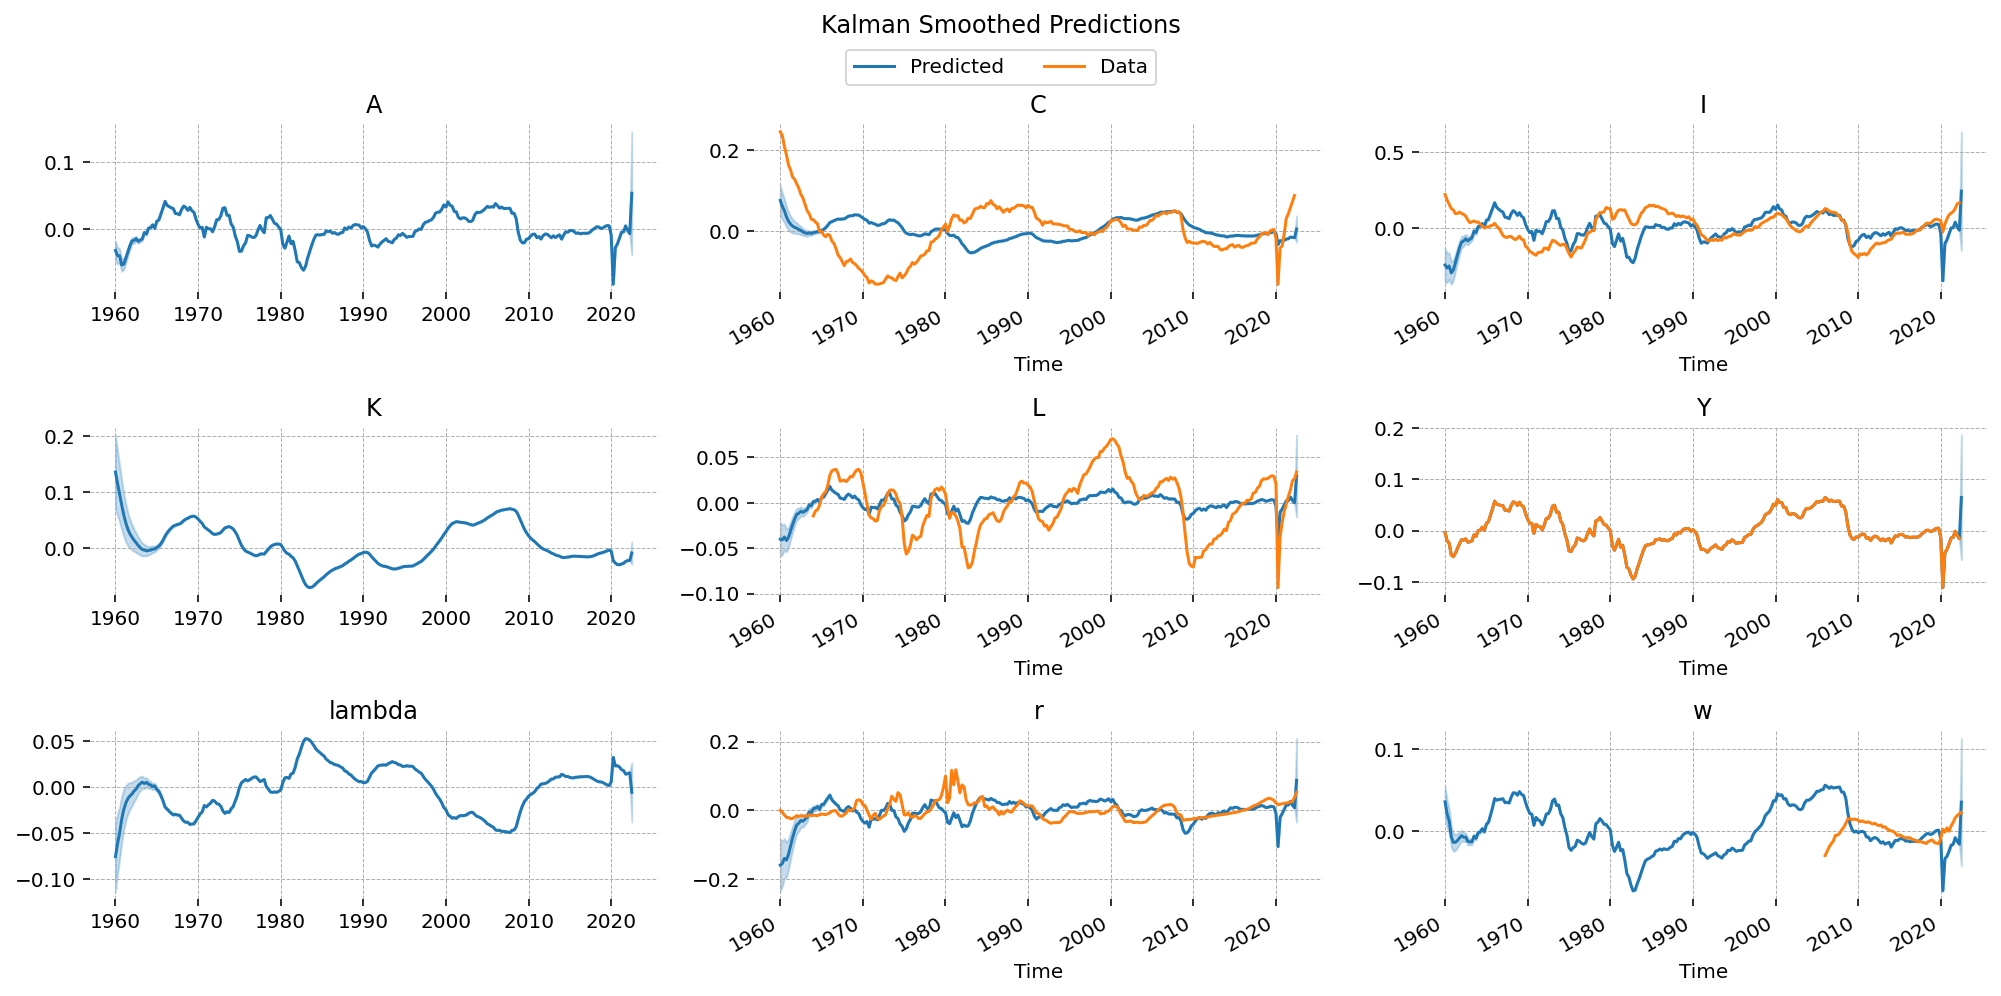

In [79]:
plot_sm_results(map_res, 'smoothed')

# Full Bayes

MAP looks too confident, and MLE looks totally untrustworthy. The next option is to go full Bayes. Instead of maximizing the posterior, we will compute the whole thing. Unfortunately, that's impossible. Fortunately, we don't need to. We can obtain the posterior via Monte Carlo Markov Chain (MCMC) sampling.

In [133]:
from importlib import reload
import gEcon
gm = reload(gEcon.classes.model)

In [136]:
rbc = gm.gEconModel('GCN Files/RBC_complete.gcn')
rbc.steady_state(verbose=False)
rbc.solve_model(verbose=False)

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [140]:
# idata = rbc.fit(df,
#                 n_walkers = 50, 
#                 draws=10_000, 
#                 burn_in=2500, 
#                 return_inferencedata=True)

# idata.to_netcdf('rbc_idata.netcdf')
idata = az.from_netcdf('rbc_idata.netcdf')

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [26:24<00:00,  6.31it/s]
C:\Users\Jesse\miniconda3\envs\econ\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


'rbc_idata.netcdf'

In [141]:
deep_params = ['sigma_C', 'sigma_L', 'alpha', 'rho_A', 'epsilon_A']

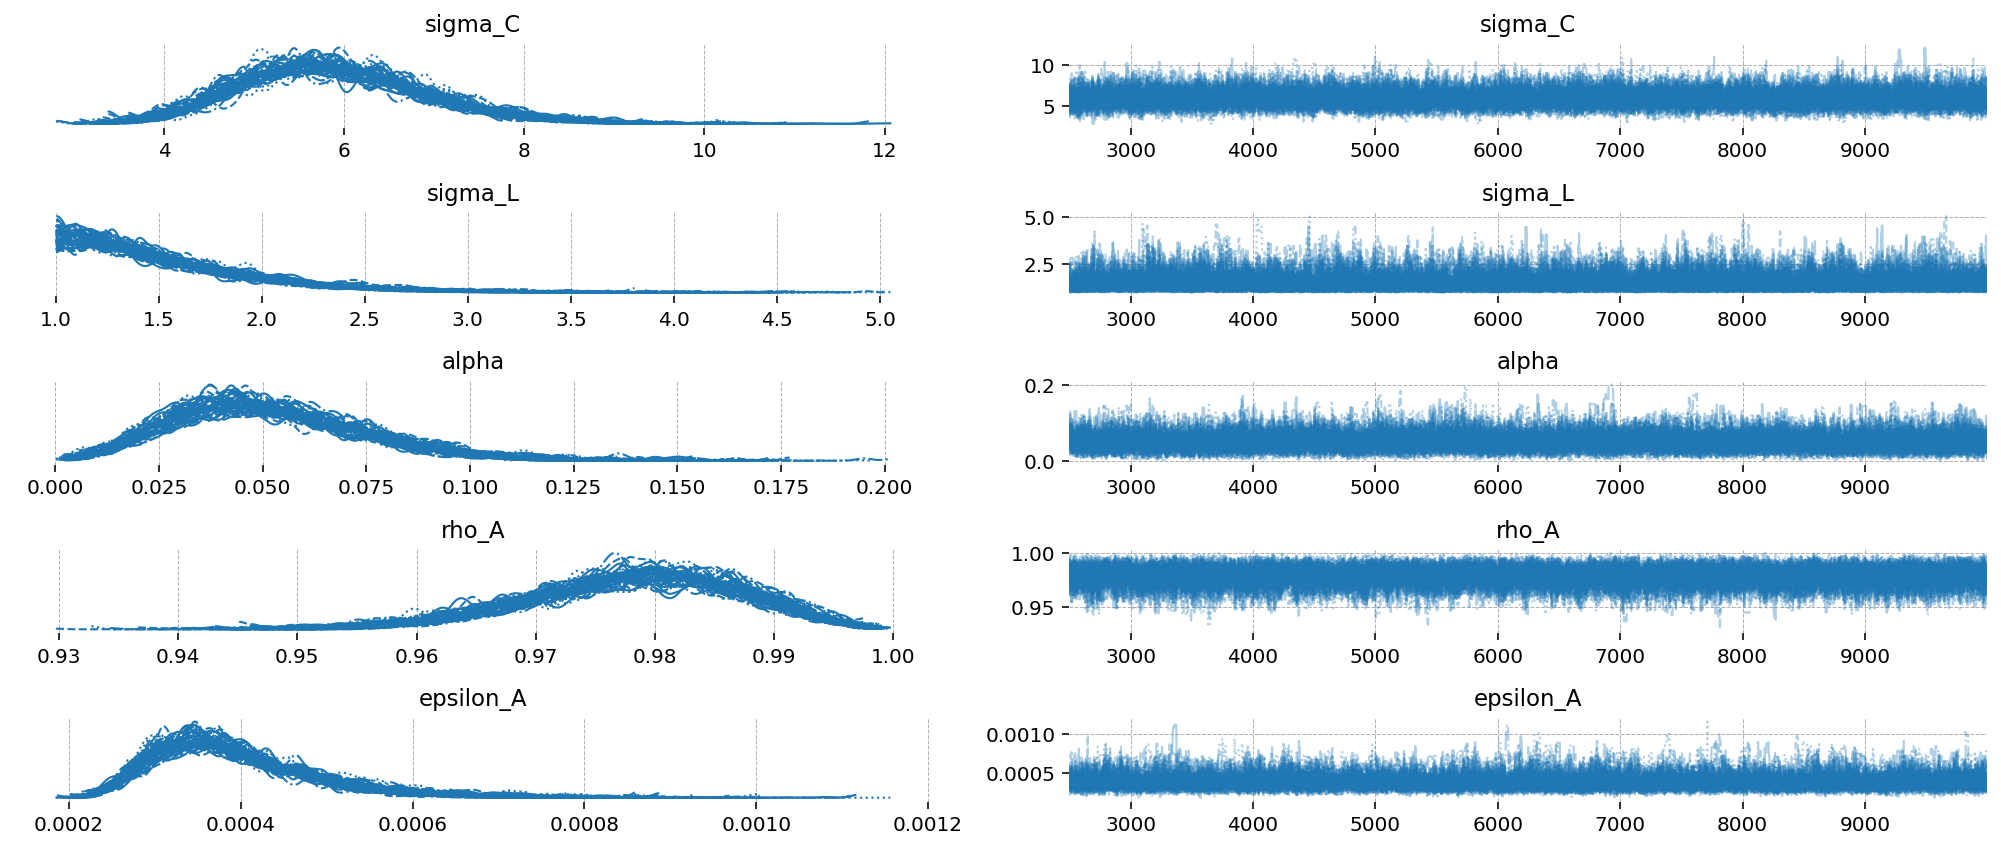

In [142]:
fig, ax = plt.subplots(len(deep_params), 2, figsize=(14,6))
az.plot_trace(idata, axes=ax, var_names=deep_params)
fig.tight_layout()
plt.show()

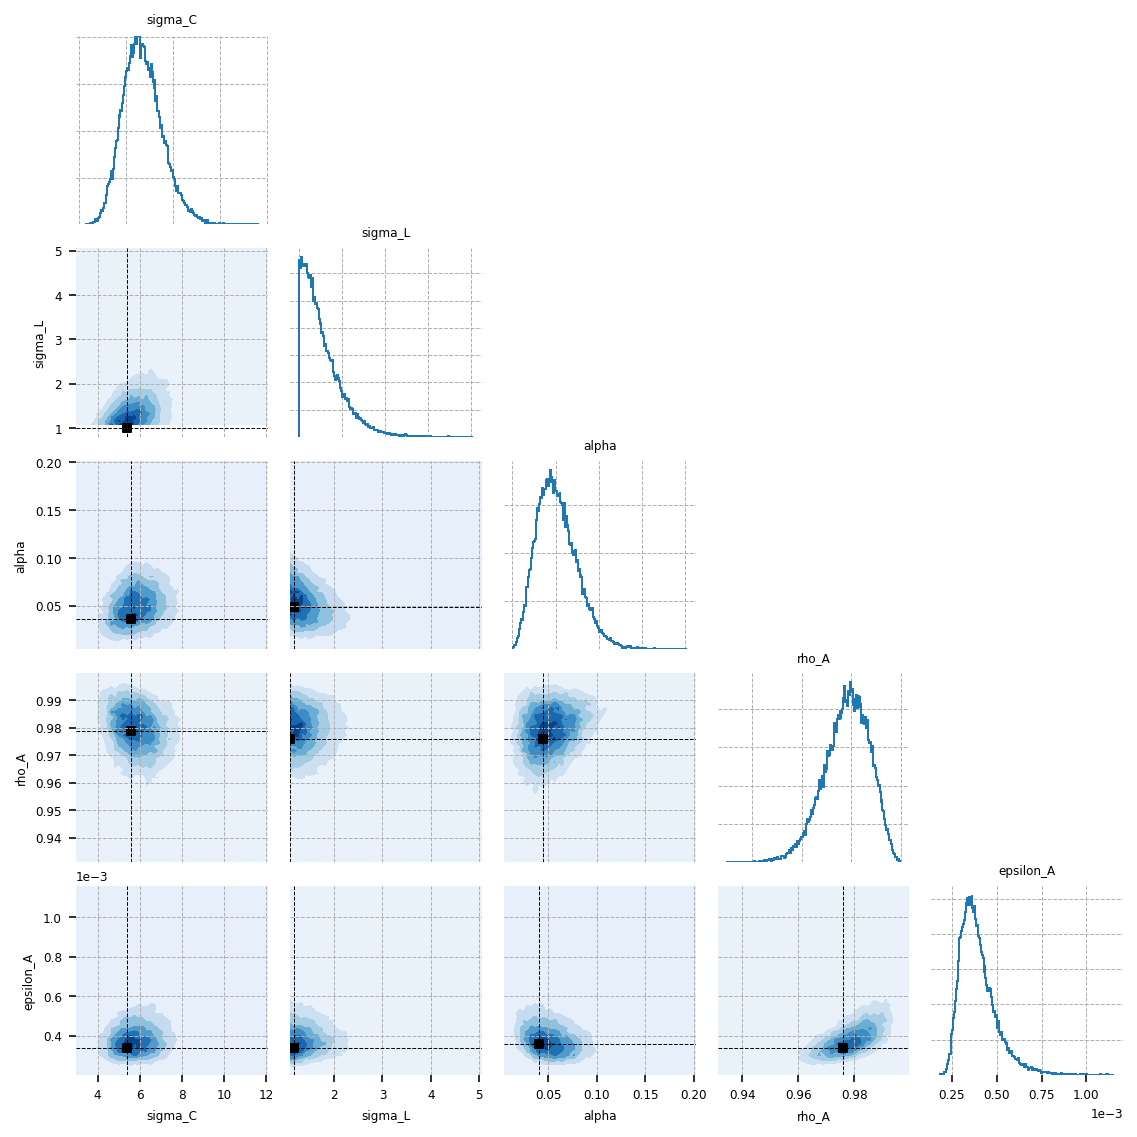

In [143]:
gp.plot_corner(idata, var_names = deep_params, show_marginal_modes=True, figsize=(8, 8), dpi=144, fontsize=6)

In [144]:
posterior = az.extract_dataset(idata, 'posterior')

In [145]:
conditional_posterior = kalman_filter_from_posterior(rbc, df, posterior, n_samples=10_000)

Sampling 10000 / 10000 [==================================================] elapsed: 02:07, remaining: 00:00, 78.48iter/secer


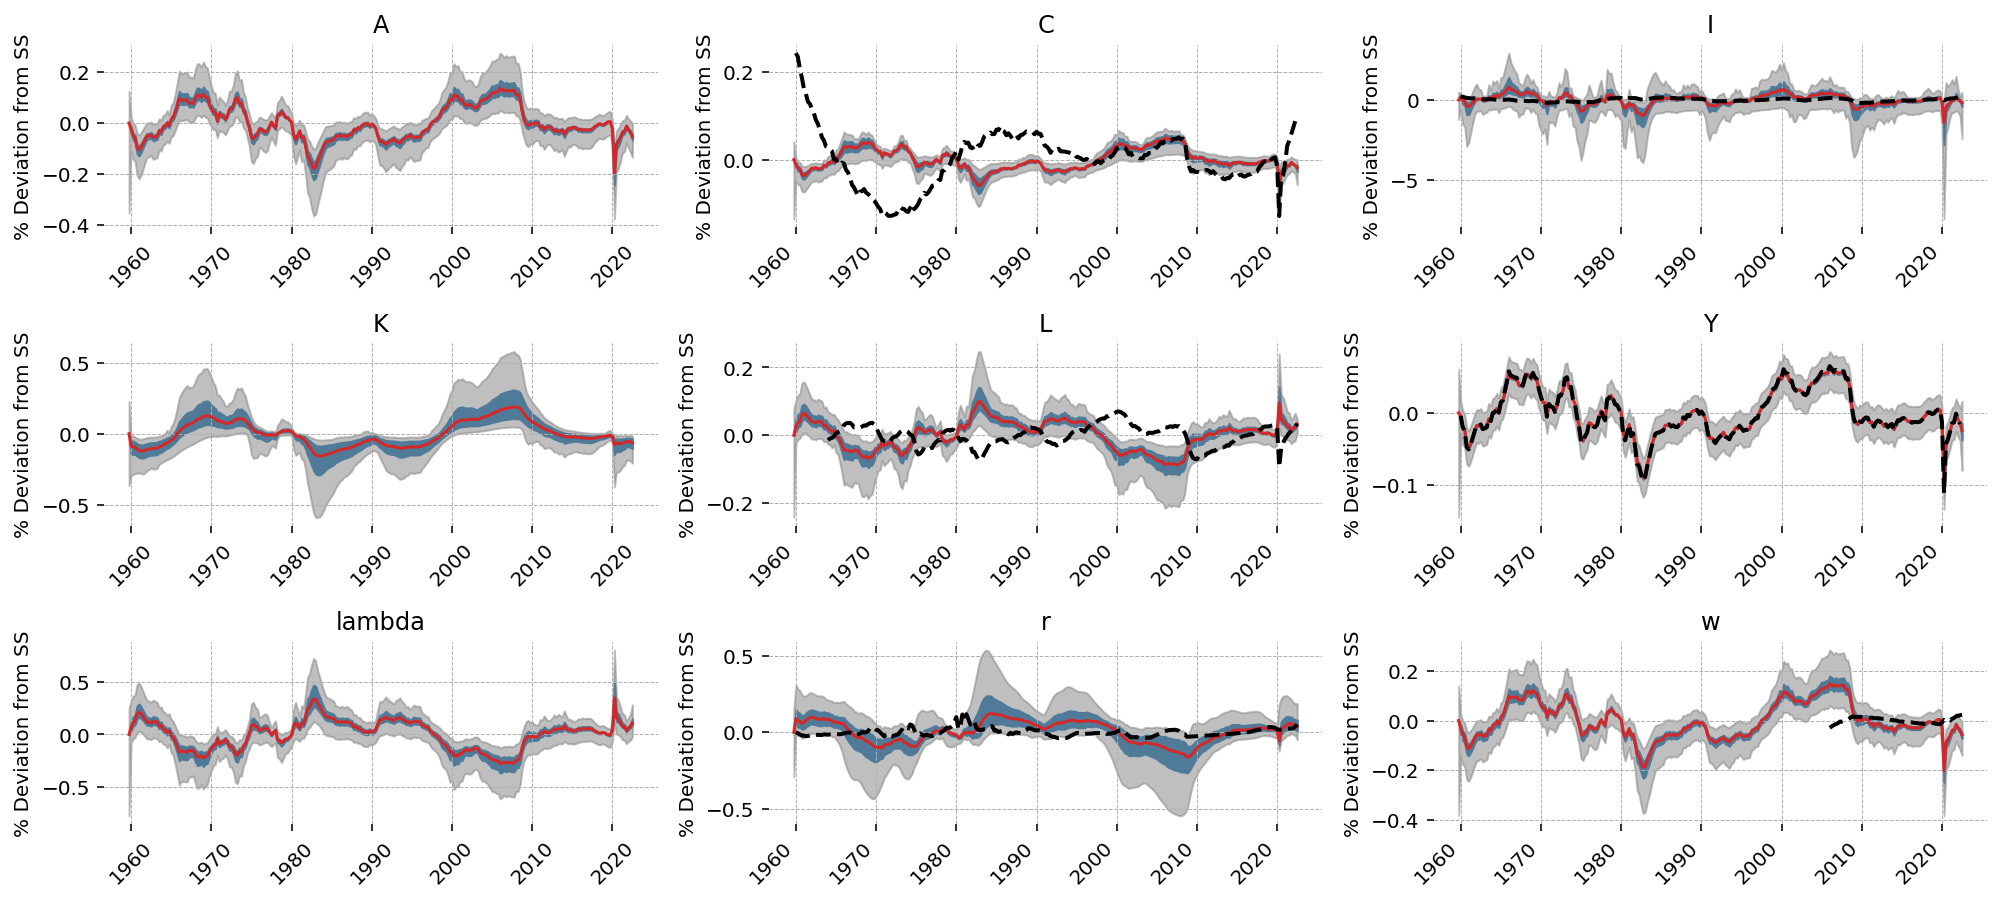

In [148]:
gp.plot_kalman_filter(conditional_posterior, df, 'predicted', n_cols=3, figsize=(14,8))